<a href="https://colab.research.google.com/github/kimgeonhee317/sd-workspace/blob/main/template/Img2Img_SDLX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup


### 1. Module and libraries


In [1]:
# pip module download
!pip install diffusers --upgrade
!pip install -q invisible_watermark accelerate transformers ftfy bitsandbytes==0.35.0 natsort safetensors xformers scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.1/989.1 kB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.8 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.20.2-py3-none-any.whl size=1342633 sha256=a10d6060caf2e73596331fb1fe32181b63377fc201dc15fccec22576dddb6184
  Stored in directory: /root/.cache/pip/wheels/dc/8b/d9/34f7a1936109e05e9bba0cc2241a6f8cd89e25959dc7aae942
Successfully built diffusers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.6 MB/s eta 0:00:00
     ━━━━━

In [2]:
# import library
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline
from diffusers.utils import load_image

### 2. Model

In [5]:
# https://huggingface.co/stabilityai/stable-diffusion-2-1
# model_id = "stabilityai/stable-diffusion-2-1"

# https://huggingface.co/stablediffusionapi/disneypixar
#model_id = "stablediffusionapi/disneypixar"

#https://huggingface.co/stabilityai/stable-diffusion-xl-base-1.0
# model_id = "stabilityai/stable-diffusion-xl-base-1.0"

# https://huggingface.co/stabilityai/stable-diffusion-xl-refiner-1.0
model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"

### 3. Pipe setting

In [8]:
# pipe setting
pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

pipe = pipe.to("cuda")
#pipe.enable_model_cpu_offload()

pipe.enable_attention_slicing()
pipe.enable_xformers_memory_efficient_attention()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
pipe.enable_model_cpu_offload() # if it's cpu

### 4. Scheduler

In [9]:
from diffusers import DPMSolverMultistepScheduler, EulerDiscreteScheduler
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
#pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

pipe.scheduler

DPMSolverMultistepScheduler {
  "_class_name": "DPMSolverMultistepScheduler",
  "_diffusers_version": "0.20.2",
  "algorithm_type": "dpmsolver++",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "dynamic_thresholding_ratio": 0.995,
  "interpolation_type": "linear",
  "lambda_min_clipped": -Infinity,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_type": "midpoint",
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "use_karras_sigmas": false,
  "variance_type": null
}

### 5. Function and Variables

In [10]:
from PIL import Image

def grid_img(imgs, rows=1, cols=3, scale=1):
  assert len(imgs) == rows * cols

  w, h = imgs[0].size
  w, h = int(w*scale), int(h*scale)

  grid = Image.new('RGB', size=(cols*w, rows*h))
  grid_w, grid_h = grid.size

  for i, img in enumerate(imgs):
      img = img.resize((w,h), Image.ANTIALIAS)
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

In [11]:
seed = 317

## Prompt

### 1. Positive
+ art : Painting, Photo, Drawing, 3D rendering, Oil painting, watercolor painting, Portrait, Sketch, Digital painting, Concept art, Ultra realistic illustration, Underwater portrait, Underwater steampunk
+ style: realistic, hyperrealistic, pop-art, modernist, art nouveau, surrealist
+ color: vivid, tones or colors, bw (black and white),vintage, gold, silver, etc.
+ artist: Van Gogh, John Collier, Monet, Alphonse Mucha, Salvador Dali, Rembrandt, Da Vinci, etc.
(https://www.urania.ai/top-sd-artists)
+ resolution: highly detailed, unreal engine (detailed and realistic 3D), sharp focus, hd, 4k or 8k, vray (3D renderizations - good results for landscapes)
+ site: artstation (art and design), pixabay, unsplash, pexels, pixiv (Japanese virtual community. It will return anime-style images)
+ others:
  + Ilumination: cinematic lighting, rim lighting, natural light, side light, sunset or golden hour
Change the vibe: dramatic, sci-fi, dystopian.

  + Add more aesthetics: stunningly beautiful, award winning photo, masterpiece.

  + Terms associated with photography (camera millimeter): 35mm, 50mm, 80mm, 85mm, wide angle, analog, fisheye lens, gopro, dslr, film, tilt-shift.

  + etc: blurred background, psychodelic, low angle shot, frontal face, expansive, detailed clothing



In [122]:
desc = "photography of girl walking along the castle wall, very pretty, warm, pastel colors, daylight, happy" # subject, action, location
adjective = "beautiful peaceful background, masterpiece, best quality"
style = ",  "
color = ", "
artist = ", "
resolution = ", 4k, highly detailed"
#site = ""
other = ", "

prompt = desc + adjective + resolution
#prompt = "young Disney socialite, small neckless, cute-fine-face, anime. illustration, realistic shaded perfect face, brown hair, grey eyes, fine details, realistic shaded lighting by ilya kuvshinov giuseppe dangelico pino and michael garmash and rob rey, iamag premiere, wlop matte print, 4k resolution, a masterpiece"
print(len(prompt.split(" ")))

23


### 2. Negative


In [109]:
desc = "bad anatomy, ugly, deformed, distorted face, poorly drawn hands, poorly drawn face, poorly drawn feet"
#neg_prompt = "deformed, distorted face, ugly face, pooly drawn face, ugly, ugly arms, ugly hands,ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, extra limbs"
item = ", bags"
neg_prompt = desc + "worst quality"
print(len(neg_prompt.split(" ")))

16


### 3. Parameter

In [117]:
seed = 7771342
steps = 40 # inference step (0~50), default = 40, larger->detailed
cfg = 5 # how the model calculation closer to text (5~9), higer-> strict

strength=0.5 # strength of model, not original image

## Implementation

In [15]:
print(pipe.scheduler)

DPMSolverMultistepScheduler {
  "_class_name": "DPMSolverMultistepScheduler",
  "_diffusers_version": "0.20.2",
  "algorithm_type": "dpmsolver++",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "dynamic_thresholding_ratio": 0.995,
  "interpolation_type": "linear",
  "lambda_min_clipped": -Infinity,
  "lower_order_final": true,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "solver_order": 2,
  "solver_type": "midpoint",
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "use_karras_sigmas": false,
  "variance_type": null
}



### Loading image

In [ ]:
from PIL import Image
import os

current_directory = os.getcwd()
print(current_directory)

init_img = Image.open('./DSCF0099.JPG')
init_img.thumbnail((1024, 1024))
init_img

  0%|          | 0/20 [00:00<?, ?it/s]

<ipython-input-10-e1b143025a31>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((w,h), Image.ANTIALIAS)


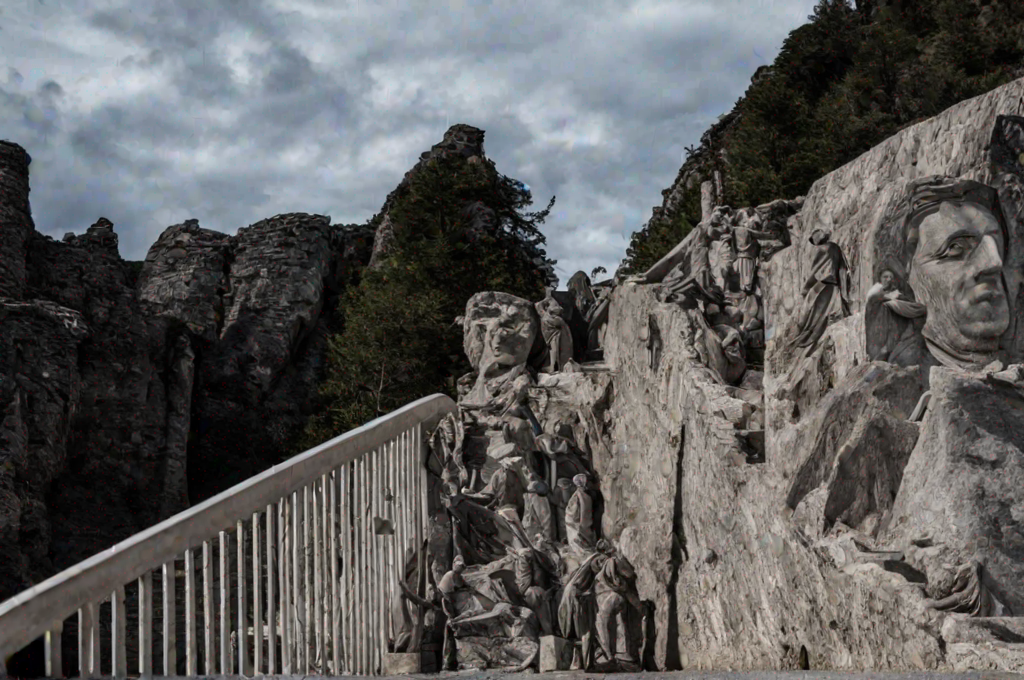

In [120]:
num_imgs = 1
imgs = pipe(prompt,
            #negative_prompt=neg_prompt,
            num_images_per_prompt=num_imgs,
            image = init_img,
            generator=torch.Generator("cuda").manual_seed(seed),
            num_inference_steps=steps,
            guidance_scale = cfg,
            strength = strength).images

grid = grid_img(imgs, rows=1, cols=num_imgs, scale=1)
grid

### Parameter tuning

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

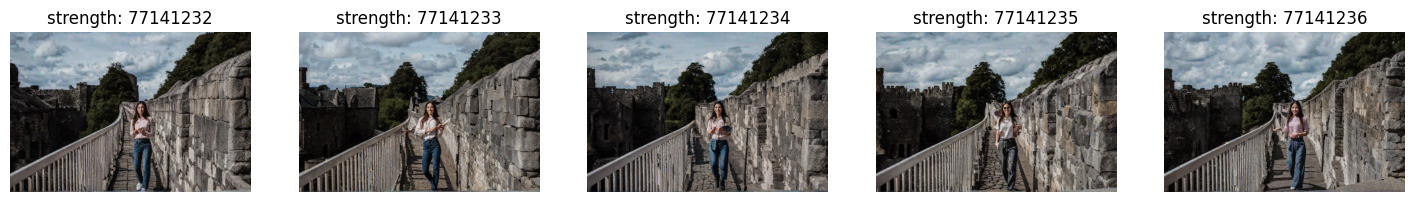

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,8))
for i in range(1, 6):

  seed = 77141231 + i
  generator = torch.Generator("cuda").manual_seed(seed)
  imgs = pipe(prompt,
              negative_prompt=neg_prompt,
              num_images_per_prompt=num_imgs,
              image = init_img,
              generator=torch.Generator("cuda").manual_seed(seed),
              num_inference_steps=steps,
              guidance_scale = cfg,
              strength = strength).images[0]

  plt.subplot(1,5,i)
  plt.title('strength: {}'.format(seed))
  plt.imshow(imgs)
  plt.axis('off')

plt.show()


In [50]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

prompt = "An astronaut riding a green horse"

images = pipe(prompt=prompt).images[0]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [49]:
torch.cuda.empty_cache()